# Develop Baseline Model for Credit Card Propensity-to-Buy Model

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

## Read Data

###  Credit Card Lead Prediction 
data source: (https://www.kaggle.com/datasets/sajidhussain3/jobathon-may-2021-credit-card-lead-prediction)

In [2]:
data_path = 'data/Credit Card Lead Prediction/train.csv'
df = pd.read_csv(data_path)
print('total data size is', df.shape[0])

total data size is 245725


In [3]:
df.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

In [4]:
label_col = 'Is_Lead'
index_col = 'ID'
feat_cols = ['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
             'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']

## Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


Only *Credit_Product* column has null value

### Gender

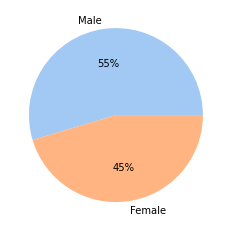

In [6]:
gender = df['Gender'].value_counts()
colors = sns.color_palette('pastel')[0:5]
plt.pie(gender, labels=gender.index, colors=colors, autopct='%.0f%%');

### Age

<AxesSubplot:xlabel='Is_Lead', ylabel='Age'>

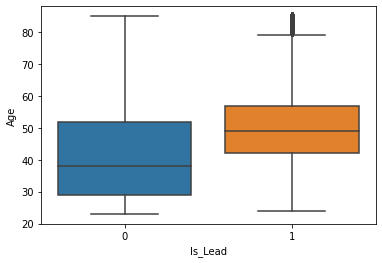

In [7]:
sns.boxplot(data=df, y='Age', x=label_col)

### Region Code

In [8]:
df['Region_Code'].value_counts()

RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64

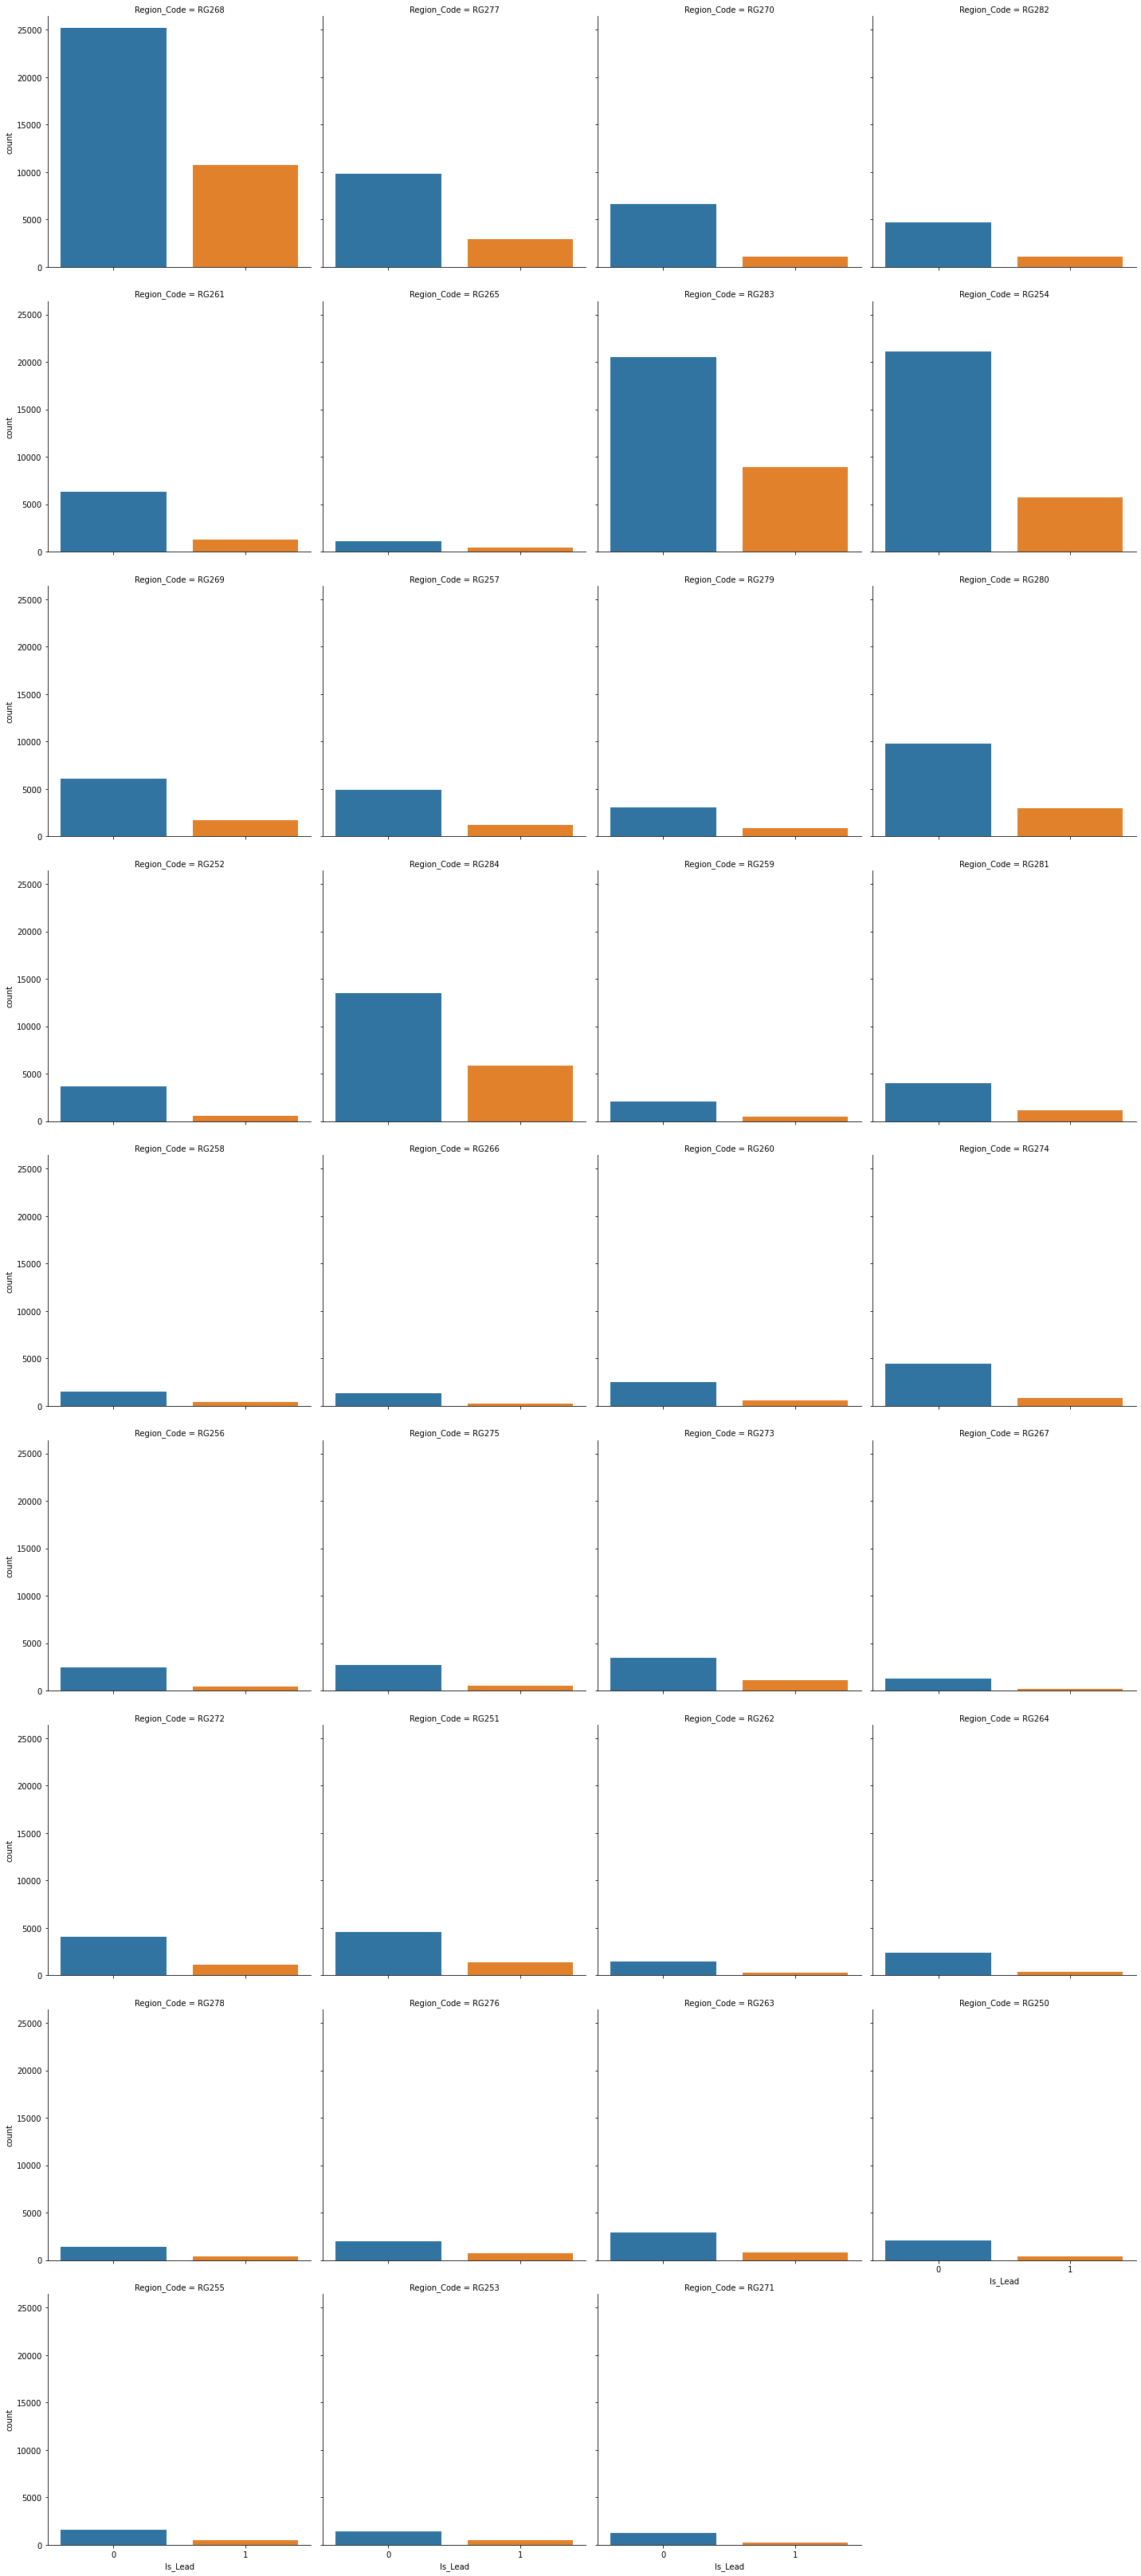

In [9]:
sns.catplot(data=df, x='Is_Lead', col='Region_Code', col_wrap=4, kind='count')

### Occupation

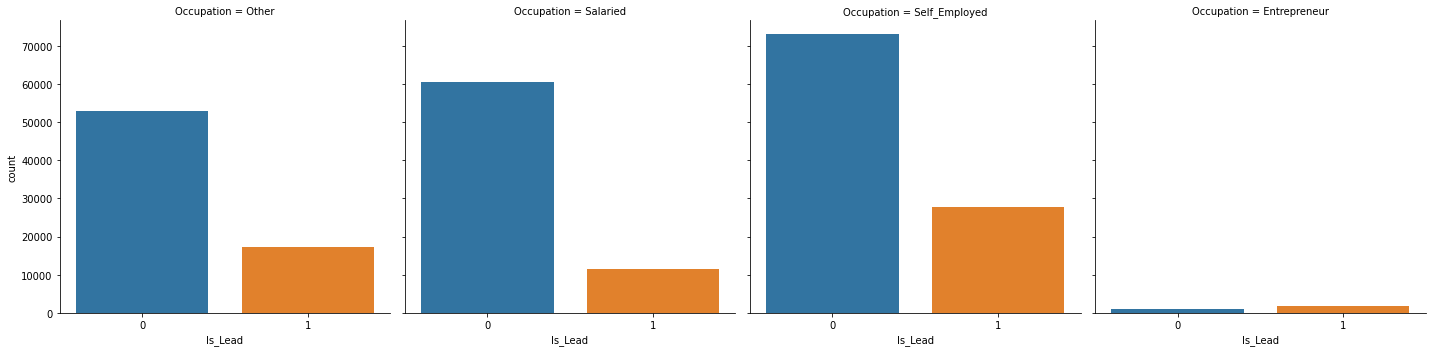

In [23]:
sns.catplot(data=df, x='Is_Lead', col='Occupation', kind='count')

### Channel Code

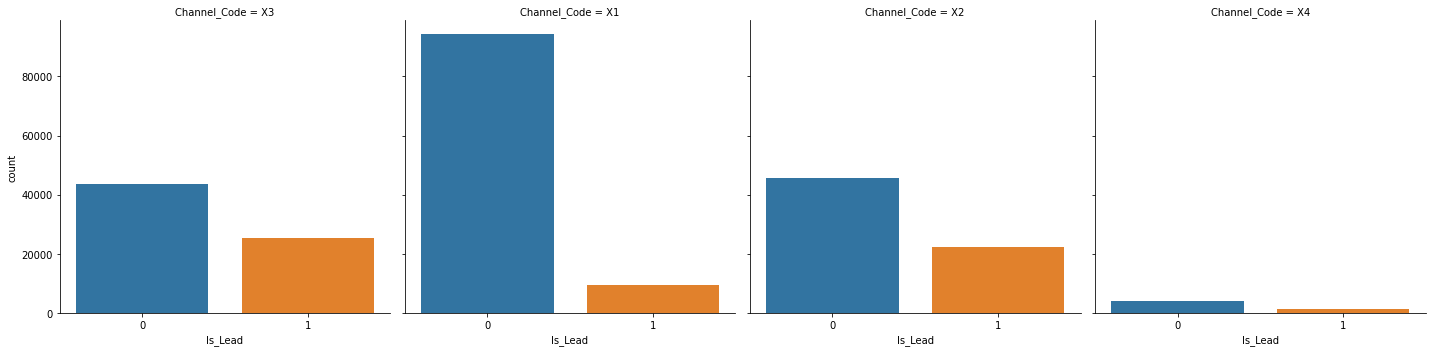

In [25]:
sns.catplot(data=df, x='Is_Lead', col='Channel_Code', kind='count')

### Vintage

<AxesSubplot:xlabel='Is_Lead', ylabel='Vintage'>

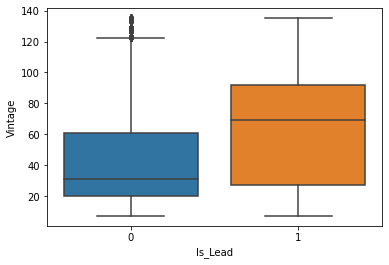

In [27]:
sns.boxplot(data=df, y='Vintage', x=label_col)

### Credit Product

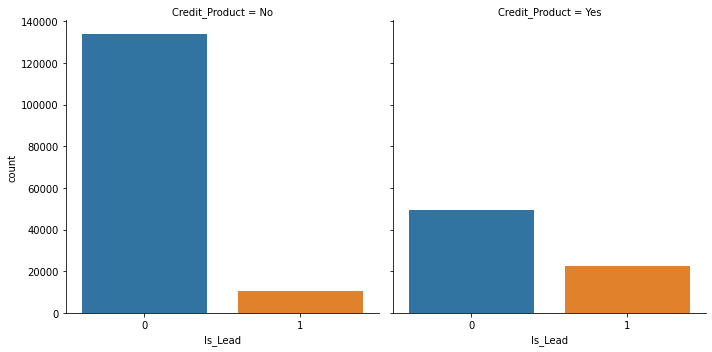

In [30]:
sns.catplot(data=df, x='Is_Lead', col='Credit_Product', kind='count')

### Avg Account Balance

<AxesSubplot:xlabel='Is_Lead', ylabel='Avg_Account_Balance'>

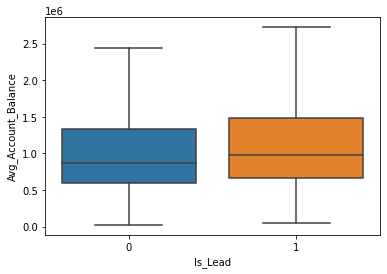

In [32]:
sns.boxplot(data=df, y='Avg_Account_Balance', x=label_col, showfliers=False)

### Active

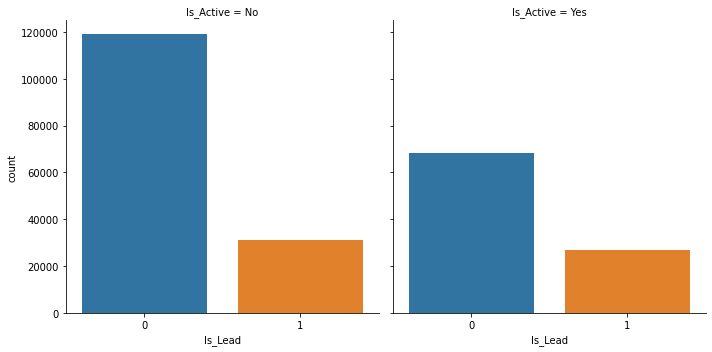

In [33]:
sns.catplot(data=df, x='Is_Lead', col='Is_Active', kind='count')

## Prepare Data for Fitting Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df[label_col], random_state=0, test_size=0.3, shuffle=True)
print('train size is', X_train.shape[0])
print('test size is', X_test.shape[0])

train size is 172007
test size is 73718


In [11]:
feat_cols

['Gender',
 'Age',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Vintage',
 'Credit_Product',
 'Avg_Account_Balance',
 'Is_Active']

### Pipeline for Preprocessing Data

In [12]:
numer_feats = ['Age', 'Vintage', 'Avg_Account_Balance']
numer_transformer = StandardScaler()


binary_feats = ['Is_Active', 'Credit_Product']
binary_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value='No')), ("ordinal", OrdinalEncoder())]
)

cat_feats = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ("num", numer_transformer, numer_feats),
        ("ordinal", binary_transformer, binary_feats),
        ("cat", cat_transformer, cat_feats)
    ], sparse_threshold = 0
)


In [13]:
transformer.fit(X_train);

In [14]:
X_train_t = transformer.transform(X_train)
X_test_t = transformer.transform(X_test)

In [15]:
transformers = transformer.get_params()['transformers']
feature_names = []
for name, _, features in transformers:
    try:
        Var = transformer.named_transformers_[name].get_feature_names().tolist()
    except AttributeError:
        Var = features
    feature_names = feature_names + Var

## Model Training

### Parameter Tuning

In [128]:
def objective(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
        'min_samples_split': trial.suggest_uniform('min_samples_split', 1e-5, 0.5),
        'min_samples_leaf': trial.suggest_uniform('min_samples_leaf', 1e-5, 0.5),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
    }
    clf = RandomForestClassifier(**params, random_state=0)
    score = cross_validate(clf, X, y, cv = 4, scoring = 'roc_auc', return_train_score=True)
    train_score = np.mean(score['train_score'])
    test_score = np.mean(score['test_score'])
    return -(test_score - 0.25 * (train_score - test_score))

In [16]:
obj_func = lambda trial: objective(trial, X_train_t, y_train)
train = False
if train:
    study = optuna.create_study(study_name='cc-model', storage='sqlite:///cc-tuning.db', load_if_exists=True)
    study.optimize(obj_func, n_trials=30)
else:
    study = optuna.load_study(study_name='cc-model', storage='sqlite:///cc-tuning.db')

In [17]:
print(study.best_params)

{'class_weight': 'balanced_subsample', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 0.0016129931401871, 'min_samples_split': 0.12614746515132008, 'n_estimators': 419}


In [18]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_train_t, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='sqrt', min_samples_leaf=0.0016129931401871,
                       min_samples_split=0.12614746515132008, n_estimators=419)

## Model Evaluation

In [19]:
y_train_score = clf.predict_proba(X_train_t)
y_test_score = clf.predict_proba(X_test_t)
y_train_pred = np.where(y_train_score[:, 1] > 0.5, 1, 0)
y_test_pred = np.where(y_test_score[:, 1] > 0.5, 1, 0)

### Classification Report

In [20]:
print("train classification report")
print(classification_report(y_train, y_train_pred))
print("test classification report")
print(classification_report(y_test, y_test_pred))

train classification report
              precision    recall  f1-score   support

           0       0.91      0.52      0.66    131189
           1       0.35      0.84      0.50     40818

    accuracy                           0.59    172007
   macro avg       0.63      0.68      0.58    172007
weighted avg       0.78      0.59      0.62    172007

test classification report
              precision    recall  f1-score   support

           0       0.91      0.52      0.66     56248
           1       0.35      0.84      0.50     17470

    accuracy                           0.59     73718
   macro avg       0.63      0.68      0.58     73718
weighted avg       0.78      0.59      0.62     73718



### ROCAUC

In [28]:
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_score[:, 1])
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_score[:, 1])

train_auc = roc_auc_score(y_train, y_train_score[:, 1])
test_auc = roc_auc_score(y_test, y_test_score[:, 1])

In [26]:
train_fpr.shape

(64132,)

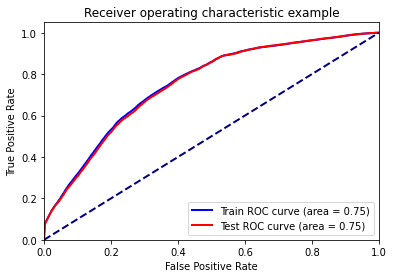

In [30]:
plt.figure()
lw = 2
plt.plot(train_fpr, train_tpr, color="b",lw=lw, label="Train ROC curve (area = %0.2f)" % train_auc)
plt.plot(test_fpr, test_tpr, color="r",lw=lw, label="Test ROC curve (area = %0.2f)" % test_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()